In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(3)

In [3]:
import jax
import jax.numpy as jnp
import scipy.stats as st
import numpy as np
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from utilities.recalibration_conformal import *
from models import seq2point
from sklearn.isotonic import IsotonicRegression
from tueplots import bundles
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

2024-04-13 22:49:16.394730: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
from jax.flatten_util import ravel_pytree

In [5]:
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

In [6]:
train = {
    1: {
        'start_time': "2011-04-28",
        'end_time': "2011-05-15"
    },
    2: {
        'start_time': "2011-04-21",
        'end_time': "2011-05-21"
    }
}
test = {
    3: {
        'start_time': "2011-04-19",
        'end_time': "2011-05-22"
    }
}
appliances = ["Dish Washer"]

In [7]:
datas = dataset_load(appliances, train, test, 99, split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test, y_test = datas[4], datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

In [8]:
training_predictions_df = pd.DataFrame()
testing_predictions_df = pd.DataFrame()
calibration_predictions_df = pd.DataFrame()
training_predictions_df["Ground Truth"] = scaler_y.inverse_transform(y_train)[
    :, 0]
calibration_predictions_df['Ground Truth'] = scaler_y.inverse_transform(y_cal)[
    :, 0]
testing_predictions_df["Timestamp"] = x_test_timestamp
testing_predictions_df["Ground Truth"] = y_test

In [9]:
def find_coverage_calib(y, y_noisy, ci, keys):
    alpha = 1 - ci                  # size = len(ci)
    k = st.norm.ppf(1 - alpha / 2)  # size = len(ci)
    q_hats = []
    coverage = np.zeros(len(ci))
    maes = []
    for i in range(len(ci)):
        if ci[i] == 0 or ci[i] == 1:
            coverage[i] = ci[i]
            q_hats.append(0)
            continue
        # E_i = []
        # for j in range(len(y)):
        #     # E_i.append(abs(y[j]-y_noisy[j] + keys[j]))
        #     E_i.append(abs(y[j]-y_noisy[j]))
        maes = abs(np.array(y).reshape(-1) -
                   np.array(y_noisy).reshape(-1)+keys)
        # E_i = maes
        q_level = np.ceil((len(y)+1)*ci[i])/len(y)
        # print("q_level: ", q_level)
        q_hat = np.quantile(maes, q_level, method='higher')
        q_hats.append(q_hat)
        upper = y_noisy + q_hat
        lower = y_noisy - q_hat
        coverage[i] = np.sum((y >= lower) & (
            y <= upper)) / len(y)
    return coverage, q_hats, maes

In [10]:
def find_coverage_train_test(y, y_noisy, ci, q_hats):
    alpha = 1 - ci                  # size = len(ci)
    k = st.norm.ppf(1 - alpha / 2)  # size = len(ci)
    coverage = np.zeros(len(ci))
    for i in range(len(ci)):
        if ci[i] == 0 or ci[i] == 1:
            coverage[i] = ci[i]
            continue
        upper = y_noisy + q_hats[i]
        lower = y_noisy - q_hats[i]
        coverage[i] = np.sum((y >= lower) & (
            y <= upper)) / len(y)
        # check if 0 is in ci array and if so, set coverage to 0 at that index

    return coverage, q_hats

In [11]:
def calib_errors(ci, coverages):
    ece = 0.0
    ace = 0.0
    for i in range(len(ci)):
        ace += abs(ci[i]-coverages[i])
    ece = ace/len(ci)
    return ace, ece

## Seq2point

In [12]:
model = seq2point.seq2point()

In [13]:
%%capture cap --no-stderr
%%time
params =  model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False, batch_size=32, learning_rate=0.001, epochs=50)

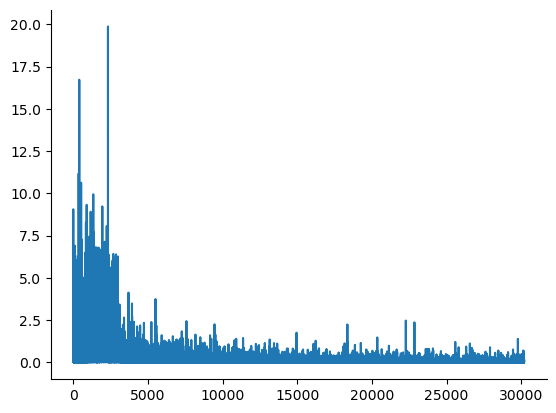

In [14]:
plt.plot(losses)
sns.despine()

In [15]:
mlp_training_time = cap.stdout.split('\n')[1]
mlp_training_time

'Wall time: 41 s'

#### Calibration Results

In [16]:
%%capture cap --no-stderr
%%time
y_hat_cal = model.apply(params, x_cal, True, rngs={
                        "dropout": jax.random.PRNGKey(0)})

In [17]:
y_hat_cal = scaler_y.inverse_transform(y_hat_cal)
y_true_cal = scaler_y.inverse_transform(y_cal)

In [18]:
print(f"RMSE : {errors.rmse(y_true_cal, y_hat_cal):.4f} MAE  : {errors.mae(y_true_cal, y_hat_cal):.4f}")

RMSE : 15.8326 MAE  : 2.4234


In [19]:
mlp_calibration_time = cap.stdout.split('\n')[1]
mlp_calibration_time

'Wall time: 949 ms'

#### Training Results

In [20]:
y_hat_train = model.apply(params, x_train, True, rngs={
                          "dropout": jax.random.PRNGKey(0)})

In [21]:
y_hat_train = scaler_y.inverse_transform(y_hat_train)
y_true = scaler_y.inverse_transform(y_train)

In [22]:
print(f"RMSE : {errors.rmse(y_true, y_hat_train):.4f} MAE  : {errors.mae(y_true, y_hat_train):.4f}")

RMSE : 11.7039 MAE  : 1.9446


#### Testing Results

In [23]:
%%capture cap
%%time
y_hat_test = model.apply(params, x_test, True, rngs={"dropout":jax.random.PRNGKey(0)})
y_hat_test = scaler_y.inverse_transform(y_hat_test)

In [24]:
mlp_testing_time = cap.stdout.split('\n')[1]
mlp_testing_time

'Wall time: 1.12 s'

In [25]:
print(f"RMSE : {errors.rmse(y_test, y_hat_test):.4f}\nMAE  : {errors.mae(y_test,y_hat_test):.4f}")

RMSE : 116.4508
MAE  : 25.5767


#### Calibration

#### Conformal

In [50]:
%%capture cap
%%time
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
keys = jax.random.normal(jax.random.PRNGKey(0), shape = (len(y_hat_cal),))*0.03
coverages_cal, q_hats, maes = find_coverage_calib(y_true_cal, y_hat_cal, ci, keys)

In [51]:
coverages_cal

array([0.        , 0.09520856, 0.18018297, 0.35881532, 0.35897038,
       0.35928051, 0.35943557, 0.93487362, 0.93502869, 0.93518375,
       1.        ])

In [52]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

In [53]:
conformal_time = cap.stdout.split('\n')[1]
conformal_time

'Wall time: 14.2 ms'

In [54]:
ace_fin_cal, ece_fin_cal = calib_errors(ci, coverages_cal)
print('Calibration:')
print(f'Final ace error is {ace_fin_cal} and ece error is {ece_fin_cal}')

Calibration:
Final ace error is 0.9108233834703054 and ece error is 0.08280212577002777


In [55]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
coverages_train, _ = find_coverage_train_test(
    y_true, y_hat_train, ci, q_hats)
coverages_train

array([0.        , 0.0922719 , 0.18154562, 0.35787025, 0.35797364,
       0.35838718, 0.35849057, 0.93657276, 0.93677953, 0.93719307,
       1.        ])

In [56]:
q_hats

[0,
 0.32571158,
 0.3943507,
 0.42878503,
 0.4504968,
 0.46622986,
 0.47954035,
 0.49239045,
 0.50687015,
 0.53058785,
 0]

In [57]:
ace_fin_train, ece_fin_train = calib_errors(ci, coverages_train)
print('Train:')
print(f'Final ace error is {ace_fin_train} and ece error is {ece_fin_train}')

Train:
Final ace error is 0.9197467045748254 and ece error is 0.08361333677952959


In [58]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
coverages_test, _ = find_coverage_train_test(
    y_test, y_hat_test, ci, q_hats)
coverages_test

array([0.        , 0.04276049, 0.08863329, 0.0947226 , 0.1064276 ,
       0.19364005, 0.19384304, 0.27009472, 0.27029771, 0.80487144,
       1.        ])

In [59]:
ace_fin_test, ece_fin_test = calib_errors(ci, coverages_test)
print(f'Final ace error is {ace_fin_test} and ece error is {ece_fin_test}')

Final ace error is 2.434709060937166 and ece error is 0.2213371873579242


In [60]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

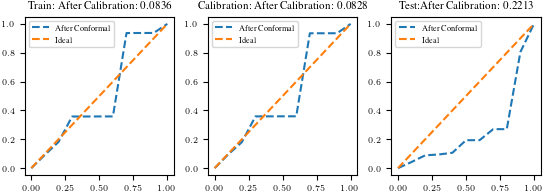

In [61]:
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (5.5, 2)})
plt.subplot(1, 3, 1)
plt.plot(ci, coverages_train, label='After Conformal', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Train: After Calibration: {"{:.4f}".format(ece_fin_train)}')
plt.legend()

# Calibration
plt.subplot(1, 3, 2)
plt.plot(ci, coverages_cal, label='After Conformal', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Calibration: After Calibration: {"{:.4f}".format(ece_fin_cal)}')
plt.legend()

# Test
plt.subplot(1, 3, 3)
plt.plot(ci, coverages_test, label='After Conformal', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Test:After Calibration: {"{:.4f}".format(ece_fin_test)}')
plt.legend()
# plt.savefig(
#     f'/home/haikoo.khandor/haikoo/conformal/con_figures/{appliances[0]}_S2P_Homo_Conformal.pdf')